# DACON : 컴퓨터 비전 학습 경진대회

https://dacon.io/competitions/official/235626/overview

팀명 : 지비

Public : 0.95588 (2위)

Private : 0.93134 (6위)

모든 코드는 코랩(Colab) 상에서 작성 및 실행되었습니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 제공받은 data.zip을 불러와서 이미지 파일들을 생성합니다.

In [2]:
!unzip -q '/content/drive/My Drive/데이콘/data.zip' -d data

In [3]:
import pandas as pd

csv_train = pd.read_csv('./data/train.csv')
csv_test = pd.read_csv('./data/test.csv')

In [4]:
csv_train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [5]:
# train 이미지들과 test 이미지들을 저장해놓을 폴더를 생성합니다.
!mkdir images_train
!mkdir images_train/0
!mkdir images_train/1
!mkdir images_train/2
!mkdir images_train/3
!mkdir images_train/4
!mkdir images_train/5
!mkdir images_train/6
!mkdir images_train/7
!mkdir images_train/8
!mkdir images_train/9
!mkdir images_test

In [6]:
import cv2

for idx in range(len(csv_train)) :
    img = csv_train.loc[idx, '0':].values.reshape(28, 28).astype(int)
    digit = csv_train.loc[idx, 'digit']
    cv2.imwrite(f'./images_train/{digit}/{csv_train["id"][idx]}.png', img)

for idx in range(len(csv_test)) :
    img = csv_test.loc[idx, '0':].values.reshape(28, 28).astype(int)
    cv2.imwrite(f'./images_test/{csv_test["id"][idx]}.png', img)

### 폴더에 저장되어있는 이미지들을 사용하여 학습할 모델을 생성합니다.

모델은 3가지이며, 최종 예측값은 최빈값(most frequent value)으로 결정합니다.

In [7]:
import tensorflow as tf

model_1 = tf.keras.applications.InceptionResNetV2(weights=None, include_top=True, input_shape=(224, 224, 1), classes=10)

model_2 = tf.keras.Sequential([
                               tf.keras.applications.InceptionV3(weights=None, include_top=False, input_shape=(224, 224, 1)),
                               tf.keras.layers.GlobalAveragePooling2D(),
                               tf.keras.layers.Dense(1024, kernel_initializer='he_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Activation('relu'),
                               tf.keras.layers.Dense(512, kernel_initializer='he_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Activation('relu'),
                               tf.keras.layers.Dense(256, kernel_initializer='he_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Activation('relu'),
                               tf.keras.layers.Dense(10, kernel_initializer='he_normal', activation='softmax', name='predictions')
                               ])

model_3 = tf.keras.Sequential([
                               tf.keras.applications.Xception(weights=None, include_top=False, input_shape=(224, 224, 1)),
                               tf.keras.layers.GlobalAveragePooling2D(),
                               tf.keras.layers.Dense(1024, kernel_initializer='he_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Activation('relu'),
                               tf.keras.layers.Dense(512, kernel_initializer='he_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Activation('relu'),
                               tf.keras.layers.Dense(256, kernel_initializer='he_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Activation('relu'),
                               tf.keras.layers.Dense(10, kernel_initializer='he_normal', activation='softmax', name='predictions')
                               ])

In [8]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ImageDataGenerator은 이미지에 대한 회전이나 이동 등의 전처리를 정말 쉽게 수행하게 해줍니다.

전체 2048개의 train 이미지 중에 20%(406개)는 validation으로 사용합니다.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

train_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), color_mode='grayscale', class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory('./images_train', target_size=(224,224), color_mode='grayscale', class_mode='categorical', subset='validation')

Found 1642 images belonging to 10 classes.
Found 406 images belonging to 10 classes.


ModelCheckpoint를 통해 val_accuracy가 가장 좋게 나온 epoch에서 모델을 저장할 수 있습니다.

h5 파일으로 구글 드라이브에 저장하므로 Colab의 연결이 끊겨도 다음에 저장된 모델을 다시 불러올 수 있습니다.

In [10]:
checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(f'./drive/My Drive/데이콘/model_1.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(f'./drive/My Drive/데이콘/model_2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
checkpoint_3 = tf.keras.callbacks.ModelCheckpoint(f'./drive/My Drive/데이콘/model_3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# 모델 학습

In [11]:
model_1.fit_generator(train_generator, epochs=500, validation_data=val_generator, callbacks=[checkpoint_1])
model_2.fit_generator(train_generator, epochs=500, validation_data=val_generator, callbacks=[checkpoint_2])
model_3.fit_generator(train_generator, epochs=500, validation_data=val_generator, callbacks=[checkpoint_3])
# 출력 결과를 보여드리기 위해서 임시로 epochs=20 으로 설정하고 실행하였습니다.
# 실제로는 epochs=500 으로 설정하고 실행해야 하며, 많은 시간이 소요됩니다.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 1.8758 - accuracy: 0.3581
Epoch 00001: val_accuracy improved from -inf to 0.09606, saving model to ./drive/My Drive/데이콘/model_1.h5
52/52 [==============================] - 32s 617ms/step - loss: 1.8758 - accuracy: 0.3581 - val_loss: 2.7777 - val_accuracy: 0.0961
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 1.0887 - accuracy: 0.6230
Epoch 00002: val_accuracy improved from 0.09606 to 0.11330, saving model to ./drive/My Drive/데이콘/model_1.h5
52/52 [==============================] - 18s 338ms/step - loss: 1.0887 - accuracy: 0.6230 - val_loss: 5.4689 - val_accuracy: 0.1133
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.7874 - accuracy: 0.7308
Epoch 00003: val_accuracy did not improve from 0.11330
52/52 [==============================] - 12s 236ms/step - loss: 0.7874 - accuracy: 0.7308 - val_loss: 3.7069 -

학습한 모델의 accuracy와 val_accuracy를 시각화합니다.

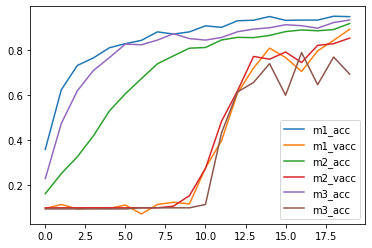

In [12]:
import matplotlib.pyplot as plt

plt.plot(model_1.history.history["accuracy"], label='m1_acc')
plt.plot(model_1.history.history["val_accuracy"], label='m1_vacc')

plt.plot(model_2.history.history["accuracy"], label='m2_acc')
plt.plot(model_2.history.history["val_accuracy"], label='m2_vacc')

plt.plot(model_3.history.history["accuracy"], label='m3_acc')
plt.plot(model_3.history.history["val_accuracy"], label='m3_acc')

plt.legend()
plt.show()

# 결과(예측값) 확인

checkpoint를 통해 저장했던 h5 파일들을 불러옵니다.

In [13]:
model_1 = tf.keras.models.load_model('./drive/My Drive/데이콘/model_1.h5', compile=False)
model_2 = tf.keras.models.load_model('./drive/My Drive/데이콘/model_2.h5', compile=False)
model_3 = tf.keras.models.load_model('./drive/My Drive/데이콘/model_3.h5', compile=False)

test 이미지들에 대해 ImageDataGenerator를 사용하기 위해 가상의 클래스인 none 폴더를 생성하여 모든 png 파일들을 none 폴더로 이동합니다.

In [17]:
!mkdir images_test/none
!mv images_test/*.png images_test/none

In [18]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory('./images_test', target_size=(224,224), color_mode='grayscale', class_mode='categorical', shuffle=False)

Found 20480 images belonging to 1 classes.


In [19]:
predict_1 = model_1.predict_generator(test_generator).argmax(axis=1)
predict_2 = model_2.predict_generator(test_generator).argmax(axis=1)
predict_3 = model_3.predict_generator(test_generator).argmax(axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


# 제출용 csv 파일 생성하기

3가지 예측값 중에서 최빈값(most frequent value)을 최종 예측값으로 제출합니다.

In [20]:
submission = pd.read_csv('./data/submission.csv')
submission.head()

,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0


In [21]:
submission["predict_1"] = predict_1
submission["predict_2"] = predict_2
submission["predict_3"] = predict_3
submission.head()

,id,digit,predict_1,predict_2,predict_3
0,2049,0,4,4,4
1,2050,0,4,4,4
2,2051,0,6,6,6
3,2052,0,9,9,9
4,2053,0,5,5,5


In [22]:
from collections import Counter

for i in range(len(submission)) :
    predicts = submission.loc[i, ['predict_1','predict_2','predict_3']]
    submission.at[i, "digit"] = Counter(predicts).most_common(n=1)[0][0]

submission.head()

,id,digit,predict_1,predict_2,predict_3
0,2049,4,4,4,4
1,2050,4,4,4,4
2,2051,6,6,6,6
3,2052,9,9,9,9
4,2053,5,5,5,5


In [23]:
submission = submission[['id', 'digit']]
submission.head()

,id,digit
0,2049,4
1,2050,4
2,2051,6
3,2052,9
4,2053,5


In [24]:
submission.to_csv('submission_ensemble_3.csv', index=False)